In [14]:
# cell 1
# If packages are missing, run in a terminal:
# pip install pandas numpy scikit-learn networkx matplotlib xgboost openpyxl

import os, sys, platform, warnings, random, time
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from pathlib import Path
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Reproducibility & display
SEED = 42
random.seed(SEED); np.random.seed(SEED)
set_config(transform_output="pandas")
plt.rcParams["figure.dpi"] = 110

OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figs");    FIG_DIR.mkdir(exist_ok=True)

print("Python:", sys.version.split()[0], "| Platform:", platform.platform())


Python: 3.12.4 | Platform: Windows-11-10.0.26100-SP0


In [15]:
# cell 1
# If packages are missing, run in a terminal:
# pip install pandas numpy scikit-learn networkx matplotlib xgboost openpyxl

import os, sys, platform, warnings, random, time
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from pathlib import Path
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Reproducibility & display
SEED = 42
random.seed(SEED); np.random.seed(SEED)
set_config(transform_output="pandas")
plt.rcParams["figure.dpi"] = 110

OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("./figs");    FIG_DIR.mkdir(exist_ok=True)

print("Python:", sys.version.split()[0], "| Platform:", platform.platform())

Config ready ✅


PaySim shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


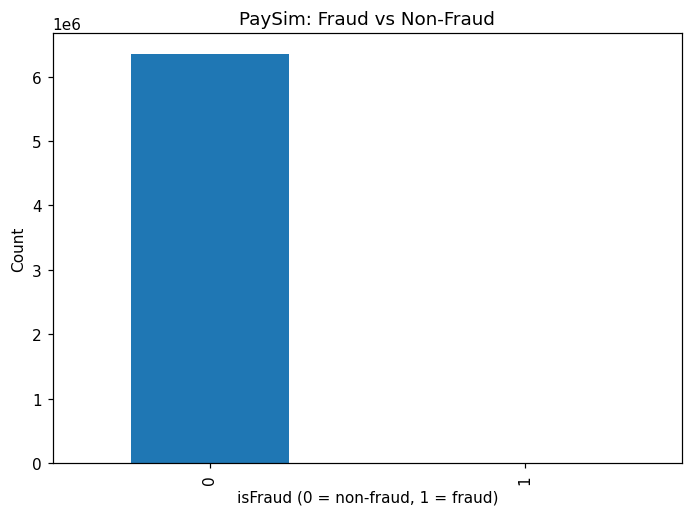

In [16]:
#cell 3
# Load PaySim
assert os.path.exists(PAYSIM_CSV), f"Missing PaySim file: {PAYSIM_CSV}"
paysim = pd.read_csv(PAYSIM_CSV)

if SAMPLE_PAYSIM_ROWS:
    paysim = paysim.sample(SAMPLE_PAYSIM_ROWS, random_state=SEED).sort_index()

print("PaySim shape:", paysim.shape)
display(paysim.head())

# EDA: class distribution
fraud_counts = paysim['isFraud'].value_counts().sort_index()
plt.figure()
fraud_counts.plot(kind='bar')
plt.title("PaySim: Fraud vs Non-Fraud")
plt.xlabel("isFraud (0 = non-fraud, 1 = fraud)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Graph |V|=9,073,900, |E|=6,362,620  built in 48.6s


,account,deg,in_deg,out_deg,btw
0,C1231006815,1,0,1,0.0
1,M1979787155,1,1,0,0.0
2,C1666544295,1,0,1,0.0
3,M2044282225,1,1,0,0.0
4,C1305486145,1,0,1,0.0


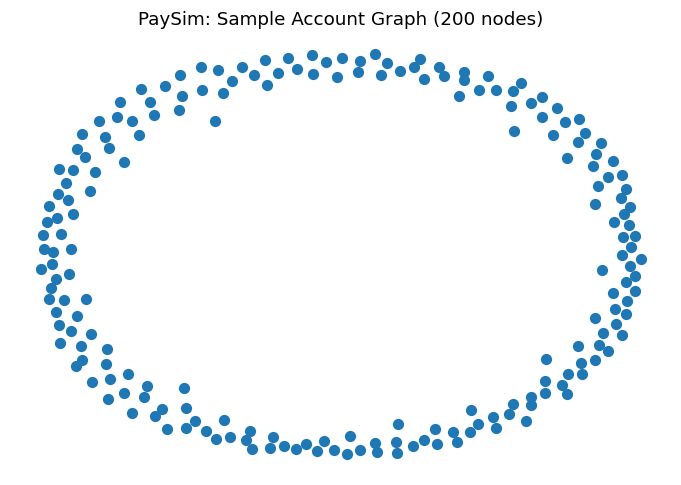

In [17]:
#cell 4
# Cast types
paysim['type'] = paysim['type'].astype('category')
paysim['nameOrig'] = paysim['nameOrig'].astype('string')
paysim['nameDest'] = paysim['nameDest'].astype('string')

# Build graph
t0 = time.time()
G = nx.from_pandas_edgelist(
    paysim, source="nameOrig", target="nameDest",
    create_using=nx.DiGraph, edge_attr=["amount","type","step"]
)
print(f"Graph |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,}  built in {time.time()-t0:.1f}s")

# SNA (degree variants; betweenness optional)
deg     = dict(G.degree())
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())
btw = {}
if DO_BETWEENNESS:
    btw = nx.betweenness_centrality(G, k=min(BETWEENNESS_SAMPLE_K, G.number_of_nodes()), seed=SEED)

accounts = pd.DataFrame({
    "account": list(G.nodes()),
    "deg": [deg.get(n,0) for n in G.nodes()],
    "in_deg": [in_deg.get(n,0) for n in G.nodes()],
    "out_deg": [out_deg.get(n,0) for n in G.nodes()],
    "btw": [btw.get(n,0.0) for n in G.nodes()],
}).pipe(memdowncast)
display(accounts.head())

# Sample graph visual
import random
sample_nodes = random.sample(list(G.nodes()), min(200, G.number_of_nodes()))
subG = G.subgraph(sample_nodes).copy()
plt.figure(figsize=(6,4))
pos = nx.spring_layout(subG, seed=42, k=0.3)
nx.draw(subG, pos, node_size=40, with_labels=False, edge_color='gray')
plt.title("PaySim: Sample Account Graph (200 nodes)")
plt.tight_layout()
plt.show()


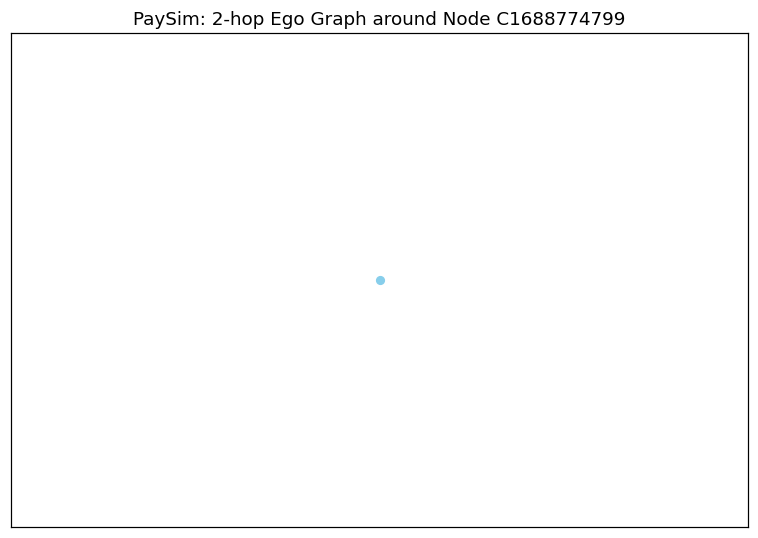

Plotted ego graph around node C1688774799 with 1 nodes and 0 edges.


In [18]:
# Cell 4a (improved ego graph viz for dissertation)

# Pick a node with high degree (not just max — max may be isolated in our sample)
high_deg_nodes = [n for n, d in deg.items() if d >= 10]  # filter for degree >=10
if not high_deg_nodes:
    high_deg_nodes = list(deg.keys())  # fallback: all nodes

seed = random.choice(high_deg_nodes)   # random high-degree node
H = nx.ego_graph(G, seed, radius=2)    # 2-hop ego graph

plt.figure(figsize=(7,5))
pos = nx.spring_layout(H, seed=42, k=0.25)
nx.draw_networkx_nodes(H, pos, node_size=25, node_color="skyblue")
nx.draw_networkx_edges(H, pos, alpha=0.4, edge_color="gray")
plt.title(f"PaySim: 2-hop Ego Graph around Node {seed}")
plt.tight_layout()
plt.savefig(FIG_DIR / "paysim_ego_graph_connected.png")
plt.show()

print(f"Plotted ego graph around node {seed} with {H.number_of_nodes()} nodes and {H.number_of_edges()} edges.")



In [19]:
#cell 5
# Join SNA
acc_map = accounts.set_index("account")
for feat in ["deg","in_deg","out_deg","btw"]:
    paysim[f"orig_{feat}"] = paysim["nameOrig"].map(acc_map[feat])
    paysim[f"dest_{feat}"] = paysim["nameDest"].map(acc_map[feat])

# Encode type
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
paysim["type_code"] = enc.fit_transform(paysim[["type"]])

# Feature matrix
pay_features = [
    "step","amount",
    "oldbalanceOrg","newbalanceOrig",
    "oldbalanceDest","newbalanceDest",
    "type_code",
    "orig_deg","orig_in_deg","orig_out_deg","orig_btw",
    "dest_deg","dest_in_deg","dest_out_deg","dest_btw"
]
X_pay = paysim[pay_features].pipe(memdowncast).fillna(0.0)
y_pay = paysim["isFraud"].astype("int8")

print("Feature matrix shape:", X_pay.shape)
print("Class distribution:\n", y_pay.value_counts(normalize=True))


Feature matrix shape: (6362620, 15)
Class distribution:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [20]:
#cell 6
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=os.cpu_count(),
    random_state=SEED, class_weight="balanced_subsample"
)
xgb = XGBClassifier(
    random_state=SEED, n_estimators=400, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, n_jobs=os.cpu_count(),
    tree_method="hist", eval_metric="aucpr"
)

Xtr, Xte, ytr, yte = train_test_split(
    X_pay, y_pay, test_size=0.2, random_state=SEED, stratify=y_pay
)

print("Training RandomForest...")
rf.fit(Xtr, ytr);   rf_scores  = rf.predict_proba(Xte)[:,1]

print("Training XGBoost...")
xgb.fit(Xtr, ytr);  xgb_scores = xgb.predict_proba(Xte)[:,1]

print("\nPaySim metrics:")
eval_model("RF (SNA)",  yte, rf_scores)
eval_model("XGB (SNA)", yte, xgb_scores)

print("\nClassification reports (threshold=0.5):")
print("RF:\n",  classification_report(yte, (rf_scores>=0.5).astype(int), digits=4))
print("XGB:\n", classification_report(yte, (xgb_scores>=0.5).astype(int), digits=4))

# Save PR curves
for name, scores in [("rf_paysim", rf_scores), ("xgb_paysim", xgb_scores)]:
    prec, rec, thr = precision_recall_curve(yte, scores)
    plt.figure(); plt.plot(rec, prec, label=name)
    plt.grid(alpha=0.3); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PaySim PR Curve - {name}"); plt.legend()
    plt.savefig(FIG_DIR / f"{name}_prcurve.png"); plt.close()

print("Saved PaySim PR curves to:", FIG_DIR.resolve())


Training RandomForest...
Training XGBoost...

PaySim metrics:
  RF (SNA) | ROC-AUC: 0.9982 | PR-AUC: 0.9305 | Precision@2000: 0.7410
 XGB (SNA) | ROC-AUC: 0.9991 | PR-AUC: 0.9645 | Precision@2000: 0.7815

Classification reports (threshold=0.5):
RF:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998   1270881
           1     0.9849    0.7523    0.8530      1643

    accuracy                         0.9997   1272524
   macro avg     0.9923    0.8761    0.9264   1272524
weighted avg     0.9997    0.9997    0.9996   1272524

XGB:
               precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999   1270881
           1     0.9526    0.8570    0.9023      1643

    accuracy                         0.9998   1272524
   macro avg     0.9762    0.9285    0.9511   1272524
weighted avg     0.9998    0.9998    0.9998   1272524

Saved PaySim PR curves to: C:\Users\Shubham\figs


Training RF (PaySim baseline, no SNA)...
Training XGB (PaySim baseline, no SNA)...

PaySim Baseline (no SNA) metrics:
   RF_base | ROC-AUC: 0.9987 | PR-AUC: 0.9514 | Precision@2000: 0.7640
  XGB_base | ROC-AUC: 0.9998 | PR-AUC: 0.9660 | Precision@2000: 0.7845

Classification reports (threshold=0.5):
RF_base:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9999   1270881
           1     0.9818    0.7864    0.8733      1643

    accuracy                         0.9997   1272524
   macro avg     0.9907    0.8932    0.9366   1272524
weighted avg     0.9997    0.9997    0.9997   1272524

XGB_base:
               precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999   1270881
           1     0.9534    0.8600    0.9043      1643

    accuracy                         0.9998   1272524
   macro avg     0.9766    0.9300    0.9521   1272524
weighted avg     0.9998    0.9998    0.9998   1272524



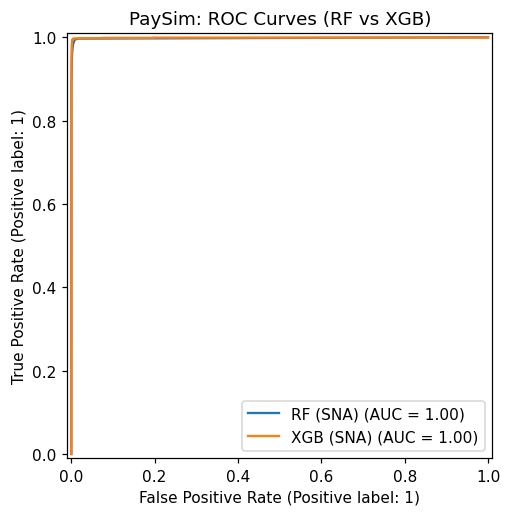

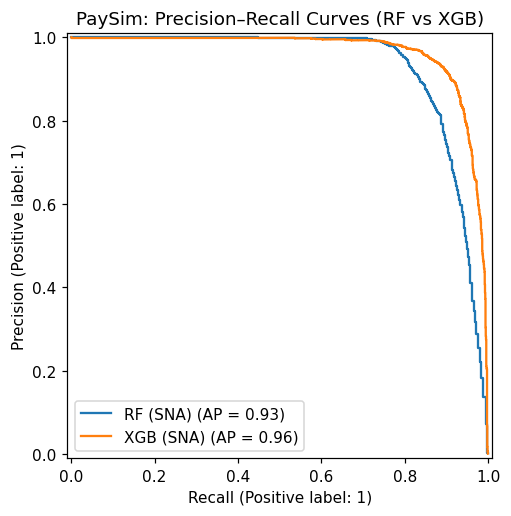

In [21]:
#cell 6a
baseline_features = [
    "step","amount",
    "oldbalanceOrg","newbalanceOrig",
    "oldbalanceDest","newbalanceDest",
    "type_code"
]
X_pay_base = paysim[baseline_features].pipe(memdowncast).fillna(0.0)
y_pay_base = paysim["isFraud"].astype("int8")

Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
    X_pay_base, y_pay_base, test_size=0.2, random_state=SEED, stratify=y_pay_base
)

rf_b = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=os.cpu_count(),
    random_state=SEED, class_weight="balanced_subsample"
)
xgb_b = XGBClassifier(
    random_state=SEED, n_estimators=400, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, n_jobs=os.cpu_count(),
    tree_method="hist", eval_metric="aucpr"
)

print("Training RF (PaySim baseline, no SNA)...")
rf_b.fit(Xtr_b, ytr_b);   rf_b_scores_pay  = rf_b.predict_proba(Xte_b)[:,1]

print("Training XGB (PaySim baseline, no SNA)...")
xgb_b.fit(Xtr_b, ytr_b);  xgb_b_scores_pay = xgb_b.predict_proba(Xte_b)[:,1]
yte_b_pay = yte_b  # alias for clarity

print("\nPaySim Baseline (no SNA) metrics:")
eval_model("RF_base",  yte_b_pay, rf_b_scores_pay)
eval_model("XGB_base", yte_b_pay, xgb_b_scores_pay)

print("\nClassification reports (threshold=0.5):")
print("RF_base:\n",  classification_report(yte_b_pay, (rf_b_scores_pay>=0.5).astype(int), digits=4))
print("XGB_base:\n", classification_report(yte_b_pay, (xgb_b_scores_pay>=0.5).astype(int), digits=4))

# Plots (PaySim ROC/PR) — optional repeat for visual report
fig = plt.figure(); ax = plt.gca()
RocCurveDisplay.from_predictions(yte, rf_scores, name="RF (SNA)", ax=ax)
RocCurveDisplay.from_predictions(yte, xgb_scores, name="XGB (SNA)", ax=ax)
plt.title("PaySim: ROC Curves (RF vs XGB)"); plt.tight_layout(); plt.show()

fig = plt.figure(); ax = plt.gca()
PrecisionRecallDisplay.from_predictions(yte, rf_scores, name="RF (SNA)", ax=ax)
PrecisionRecallDisplay.from_predictions(yte, xgb_scores, name="XGB (SNA)", ax=ax)
plt.title("PaySim: Precision–Recall Curves (RF vs XGB)"); plt.tight_layout(); plt.show()


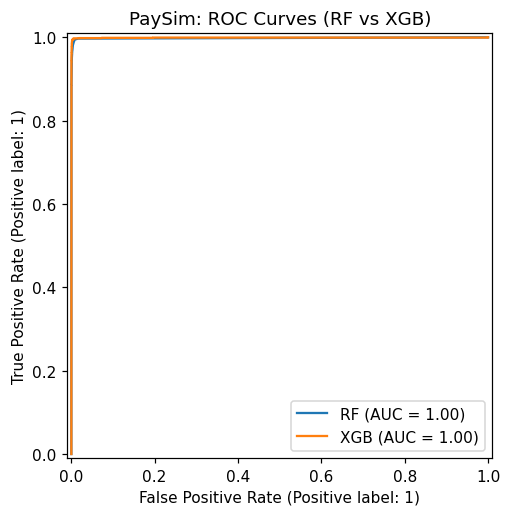

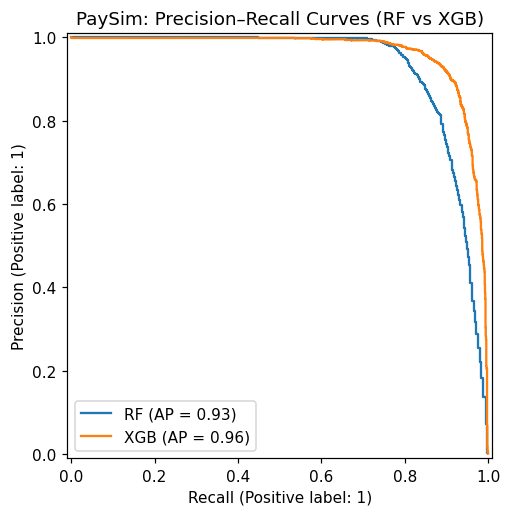

In [22]:
# Cell 6b — PaySim ROC & PR curves (RF, XGB)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# ROC curves
fig = plt.figure(); ax = plt.gca()
RocCurveDisplay.from_predictions(yte, rf_scores, name="RF", ax=ax)
RocCurveDisplay.from_predictions(yte, xgb_scores, name="XGB", ax=ax)
plt.title("PaySim: ROC Curves (RF vs XGB)")
plt.tight_layout();
plt.savefig(FIG_DIR / "paysim_roc_curves.png")
plt.show()

# PR curves
fig = plt.figure(); ax = plt.gca()
PrecisionRecallDisplay.from_predictions(yte, rf_scores, name="RF", ax=ax)
PrecisionRecallDisplay.from_predictions(yte, xgb_scores, name="XGB", ax=ax)
plt.title("PaySim: Precision–Recall Curves (RF vs XGB)")
plt.tight_layout();
plt.savefig(FIG_DIR / "paysim_pr_curves.png")
plt.show()


In [23]:
#cell 6c
# Load Elliptic CSVs
classes  = pd.read_csv(os.path.join(ELLIPTIC_DIR, "elliptic_txs_classes.csv"))
edges    = pd.read_csv(os.path.join(ELLIPTIC_DIR, "elliptic_txs_edgelist.csv"))
features = pd.read_csv(os.path.join(ELLIPTIC_DIR, "elliptic_txs_features.csv"), header=None)

# Feature columns: txId, timeStep, f000..fxxx
features.columns = ["txId", "timeStep"] + [f"f{i:03d}" for i in range(features.shape[1]-2)]

# Normalize edges to src/dst
edges.columns = [c.strip() for c in edges.columns]
edges = edges.rename(columns={edges.columns[0]: "src", edges.columns[1]: "dst"})

print("Elliptic loaded ✅")
print("  features:", features.shape, "  classes:", classes.shape, "  edges:", edges.shape)


Elliptic loaded ✅
  features: (203769, 167)   classes: (203769, 2)   edges: (234355, 2)


Elliptic shapes:
  Features: (203769, 167) | Classes: (203769, 3) | Supervised: (46564, 168)


,txId,timeStep,f000,f001,f002,f003,f004,f005,f006,f007,...,f156,f157,f158,f159,f160,f161,f162,f163,f164,label
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,1.0
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,1.0
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1.0
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,1.0


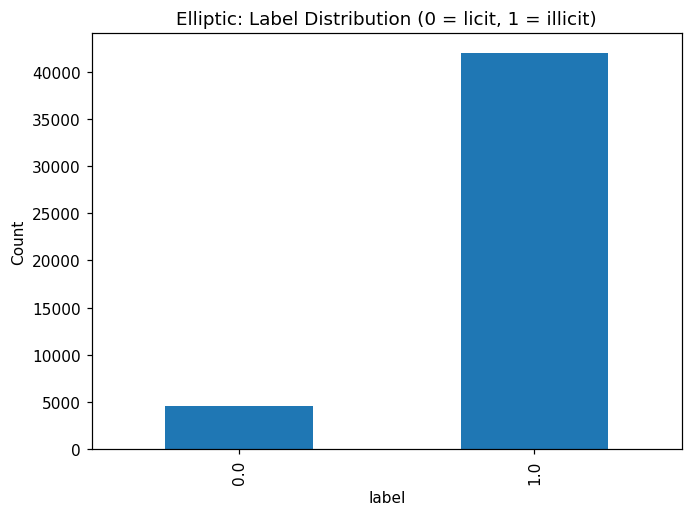

In [24]:
#cell 7
# Map "class" to label: 1=licit(0), 2=illicit(1), unknown=NaN
label_map = {"1": 0, "2": 1, "unknown": np.nan}
classes["label"] = classes["class"].astype(str).str.lower().map(label_map)

elliptic_df = features.merge(classes[["txId","label"]], on="txId", how="left")
sup_elliptic = elliptic_df.dropna(subset=["label"]).copy()
sup_elliptic.loc[:, "label"] = sup_elliptic["label"].astype("int8")

print("Elliptic shapes:")
print("  Features:", features.shape, "| Classes:", classes.shape, "| Supervised:", sup_elliptic.shape)
display(sup_elliptic.head())

# Class distribution (labelled only)
ell_counts = sup_elliptic['label'].value_counts().sort_index()
plt.figure()
ell_counts.plot(kind='bar')
plt.title("Elliptic: Label Distribution (0 = licit, 1 = illicit)")
plt.xlabel("label"); plt.ylabel("Count"); plt.tight_layout(); plt.show()


Elliptic graph |V|=203,769, |E|=234,355 built in 0.4s
Supervised Elliptic with SNA shape: (46564, 171)


,txId,timeStep,f000,f001,f002,f003,f004,f005,f006,f007,...,f094,f095,f096,f097,f098,f099,label,tx_deg,tx_in_deg,tx_out_deg
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782743,12.414557,-0.163645,...,0.266450,0.159432,-0.159946,0.970465,1.928382,-1.457953,1.0,161,160,1
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,0.041803,0.102077,-0.164948,0.486673,1.603750,-1.458049,1.0,60,59,1
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.189492,-0.116817,-0.176401,-0.014659,-0.018849,-1.458177,1.0,2,0,2
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.190252,-0.116817,-0.177348,-0.014659,-0.018849,-1.458049,1.0,2,1,1
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,2.670308,6.119688,2.143131,-2.271409,-2.569986,-1.462757,1.0,2,1,1


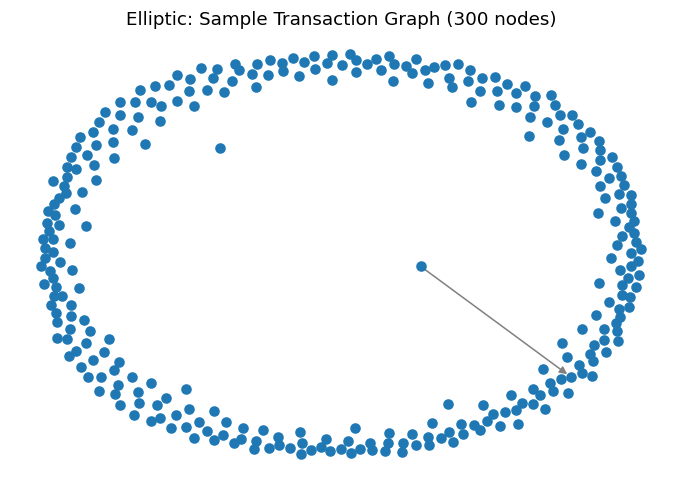

In [25]:
# Cell 8 (robust & clean — removes any old SNA cols, then merges once)

def _drop_old_sna_cols(df: pd.DataFrame) -> pd.DataFrame:
    sna_prefixes = ("tx_deg", "tx_in_deg", "tx_out_deg")
    to_drop = [c for c in df.columns if any(c.startswith(p) for p in sna_prefixes)]
    if to_drop:
        df = df.drop(columns=to_drop, errors="ignore")
    # also remove accidental duplicate columns (same name repeated)
    df = df.loc[:, ~df.columns.duplicated()]
    return df

# Build graph
t0 = time.time()
GE = nx.from_pandas_edgelist(edges, source="src", target="dst", create_using=nx.DiGraph)
print(f"Elliptic graph |V|={GE.number_of_nodes():,}, |E|={GE.number_of_edges():,} built in {time.time()-t0:.1f}s")

# Degree features
degE = dict(GE.degree())
inE  = dict(GE.in_degree())
outE = dict(GE.out_degree())

sna_tx = pd.DataFrame({
    "txId": list(GE.nodes()),
    "tx_deg":     [degE.get(n,0) for n in GE.nodes()],
    "tx_in_deg":  [inE.get(n,0)  for n in GE.nodes()],
    "tx_out_deg": [outE.get(n,0) for n in GE.nodes()],
})

# Drop any existing SNA cols (handles *_x / *_y from earlier merges)
sup_elliptic = _drop_old_sna_cols(sup_elliptic)

# Merge clean SNA features
sup_elliptic = sup_elliptic.merge(sna_tx, on="txId", how="left").fillna(0.0)
sup_elliptic = memdowncast(sup_elliptic)

print("Supervised Elliptic with SNA shape:", sup_elliptic.shape)
display(sup_elliptic.filter(regex="^(txId|timeStep|f0|label|tx_deg|tx_in_deg|tx_out_deg)").head())

# Sample graph visual (optional)
sample_nodes_e = random.sample(list(GE.nodes()), min(300, GE.number_of_nodes()))
subGE = GE.subgraph(sample_nodes_e).copy()
plt.figure(figsize=(6,4))
pos = nx.spring_layout(subGE, seed=42, k=0.3)
nx.draw(subGE, pos, node_size=35, with_labels=False, edge_color='gray')
plt.title("Elliptic: Sample Transaction Graph (300 nodes)")
plt.tight_layout(); plt.show()



In [26]:
#cell 9
X_cols = [c for c in sup_elliptic.columns if c not in ["txId","label"]]
X_ell  = sup_elliptic[X_cols]
y_ell  = sup_elliptic["label"]

Xe_tr, Xe_te, ye_tr, ye_te = train_test_split(
    X_ell, y_ell, test_size=0.2, random_state=SEED, stratify=y_ell
)

rf_e = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=os.cpu_count(),
    random_state=SEED, class_weight="balanced_subsample"
)
xgb_e = XGBClassifier(
    random_state=SEED, n_estimators=400, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, n_jobs=os.cpu_count(),
    tree_method="hist", eval_metric="aucpr"
)

print("Training RF (Elliptic)...")
rf_e.fit(Xe_tr, ye_tr);   rf_e_scores  = rf_e.predict_proba(Xe_te)[:, 1]

print("Training XGB (Elliptic)...")
xgb_e.fit(Xe_tr, ye_tr);  xgb_e_scores = xgb_e.predict_proba(Xe_te)[:, 1]

print("\nElliptic metrics:")
eval_model("RF (SNA)",  ye_te, rf_e_scores)
eval_model("XGB (SNA)", ye_te, xgb_e_scores)

print("\nClassification reports (threshold=0.5):")
print("RF:\n",  classification_report(ye_te, (rf_e_scores>=0.5).astype(int), digits=4))
print("XGB:\n", classification_report(ye_te, (xgb_e_scores>=0.5).astype(int), digits=4))

# Save PR curves
for name, scores in [("rf_elliptic", rf_e_scores), ("xgb_elliptic", xgb_e_scores)]:
    prec, rec, thr = precision_recall_curve(ye_te, scores)
    plt.figure(); plt.plot(rec, prec, label=name)
    plt.grid(alpha=0.3); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Elliptic PR Curve - {name}"); plt.legend()
    plt.savefig(FIG_DIR / f"{name}_prcurve.png"); plt.close()

print("Saved Elliptic PR curves to:", FIG_DIR.resolve())


Training RF (Elliptic)...
Training XGB (Elliptic)...

Elliptic metrics:
  RF (SNA) | ROC-AUC: 0.9974 | PR-AUC: 0.9997 | Precision@2000: 1.0000
 XGB (SNA) | ROC-AUC: 0.9981 | PR-AUC: 0.9998 | Precision@2000: 1.0000

Classification reports (threshold=0.5):
RF:
               precision    recall  f1-score   support

         0.0     0.9951    0.8911    0.9402       909
         1.0     0.9884    0.9995    0.9939      8404

    accuracy                         0.9889      9313
   macro avg     0.9917    0.9453    0.9671      9313
weighted avg     0.9890    0.9889    0.9887      9313

XGB:
               precision    recall  f1-score   support

         0.0     0.9976    0.9318    0.9636       909
         1.0     0.9927    0.9998    0.9962      8404

    accuracy                         0.9931      9313
   macro avg     0.9952    0.9658    0.9799      9313
weighted avg     0.9932    0.9931    0.9930      9313

Saved Elliptic PR curves to: C:\Users\Shubham\figs


Training RF (Elliptic baseline, no SNA)...
Training XGB (Elliptic baseline, no SNA)...

Elliptic Baseline (no SNA) metrics:
   RF_base | ROC-AUC: 0.9976 | PR-AUC: 0.9997 | Precision@2000: 1.0000
  XGB_base | ROC-AUC: 0.9981 | PR-AUC: 0.9998 | Precision@2000: 1.0000

Classification reports (threshold=0.5):
RF_base:
               precision    recall  f1-score   support

         0.0     0.9975    0.8900    0.9407       909
         1.0     0.9882    0.9998    0.9940      8404

    accuracy                         0.9890      9313
   macro avg     0.9929    0.9449    0.9673      9313
weighted avg     0.9891    0.9890    0.9888      9313

XGB_base:
               precision    recall  f1-score   support

         0.0     0.9976    0.9318    0.9636       909
         1.0     0.9927    0.9998    0.9962      8404

    accuracy                         0.9931      9313
   macro avg     0.9952    0.9658    0.9799      9313
weighted avg     0.9932    0.9931    0.9930      9313



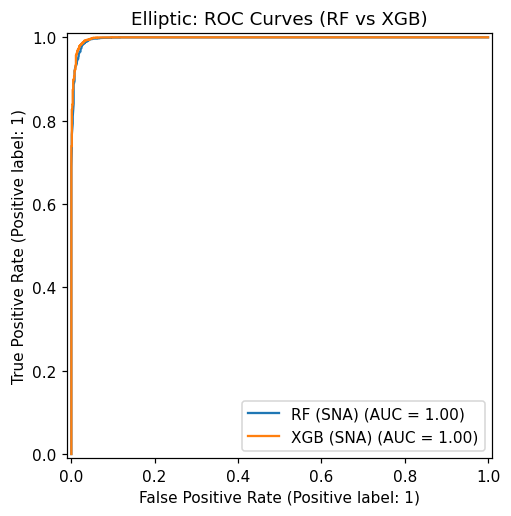

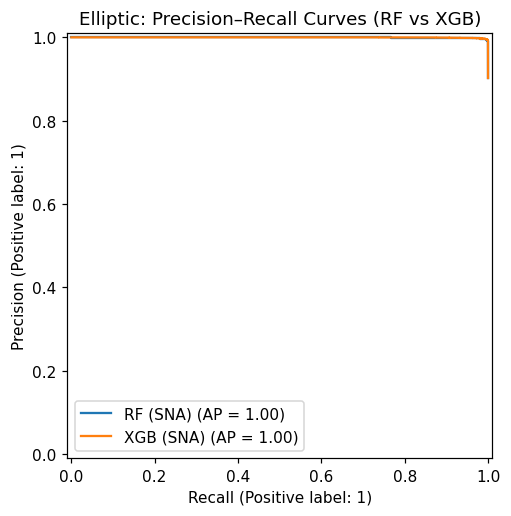

In [27]:
#cell 9
X_cols = [c for c in sup_elliptic.columns if c not in ["txId","label"]]
X_ell  = sup_elliptic[X_cols]
y_ell  = sup_elliptic["label"]

Xe_tr, Xe_te, ye_tr, ye_te = train_test_split(
    X_ell, y_ell, test_size=0.2, random_state=SEED, stratify=y_ell
)

rf_e = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=os.cpu_count(),
    random_state=SEED, class_weight="balanced_subsample"
)
xgb_e = XGBClassifier(
    random_state=SEED, n_estimators=400, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, n_jobs=os.cpu_count(),
    tree_method="hist", eval_metric="aucpr"
)

print("Training RF (Elliptic)...")
rf_e.fit(Xe_tr, ye_tr);   rf_e_scores  = rf_e.predict_proba(Xe_te)[:, 1]

print("Training XGB (Elliptic)...")
xgb_e.fit(Xe_tr, ye_tr);  xgb_e_scores = xgb_e.predict_proba(Xe_te)[:, 1]

print("\nElliptic metrics:")
eval_model("RF (SNA)",  ye_te, rf_e_scores)
eval_model("XGB (SNA)", ye_te, xgb_e_scores)

print("\nClassification reports (threshold=0.5):")
print("RF:\n",  classification_report(ye_te, (rf_e_scores>=0.5).astype(int), digits=4))
print("XGB:\n", classification_report(ye_te, (xgb_e_scores>=0.5).astype(int), digits=4))

# Save PR curves
for name, scores in [("rf_elliptic", rf_e_scores), ("xgb_elliptic", xgb_e_scores)]:
    prec, rec, thr = precision_recall_curve(ye_te, scores)
    plt.figure(); plt.plot(rec, prec, label=name)
    plt.grid(alpha=0.3); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Elliptic PR Curve - {name}"); plt.legend()
    plt.savefig(FIG_DIR / f"{name}_prcurve.png"); plt.close()

print("Saved Elliptic PR curves to:", FIG_DIR.resolve())


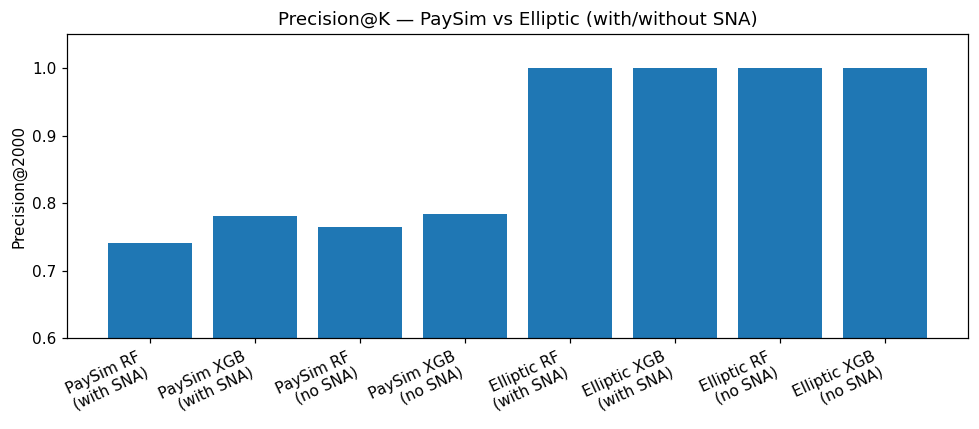

Saved Precision@K comparison bar chart to: C:\Users\Shubham\figs


In [28]:
#cell 9b
K = TOP_K_ALERTS

# PaySim (with SNA)
p_rf   = precision_at_k(yte,       rf_scores,         K)
p_xgb  = precision_at_k(yte,       xgb_scores,        K)

# PaySim baseline (no SNA)
p_rf_b  = precision_at_k(yte_b_pay,  rf_b_scores_pay,  K)
p_xgb_b = precision_at_k(yte_b_pay,  xgb_b_scores_pay, K)

# Elliptic (with SNA)
e_rf   = precision_at_k(ye_te,       rf_e_scores,       K)
e_xgb  = precision_at_k(ye_te,       xgb_e_scores,      K)

# Elliptic baseline (no SNA)
e_rf_b  = precision_at_k(ye_te_b_ell, rf_b_scores_ell,  K)
e_xgb_b = precision_at_k(ye_te_b_ell, xgb_b_scores_ell, K)

labels = [
    "PaySim RF\n(with SNA)", "PaySim XGB\n(with SNA)",
    "PaySim RF\n(no SNA)",  "PaySim XGB\n(no SNA)",
    "Elliptic RF\n(with SNA)", "Elliptic XGB\n(with SNA)",
    "Elliptic RF\n(no SNA)",  "Elliptic XGB\n(no SNA)"
]
values = [p_rf, p_xgb, p_rf_b, p_xgb_b, e_rf, e_xgb, e_rf_b, e_xgb_b]

plt.figure(figsize=(9,4))
plt.bar(labels, values)
plt.ylabel(f"Precision@{K}")
plt.ylim(0.6, 1.05)
plt.title("Precision@K — PaySim vs Elliptic (with/without SNA)")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.savefig(FIG_DIR / "precision_at_k_comparison.png")
plt.show()

print("Saved Precision@K comparison bar chart to:", FIG_DIR.resolve())


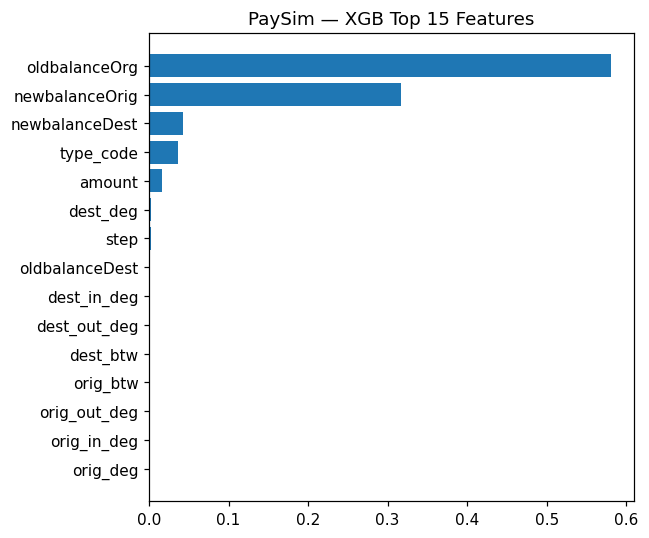

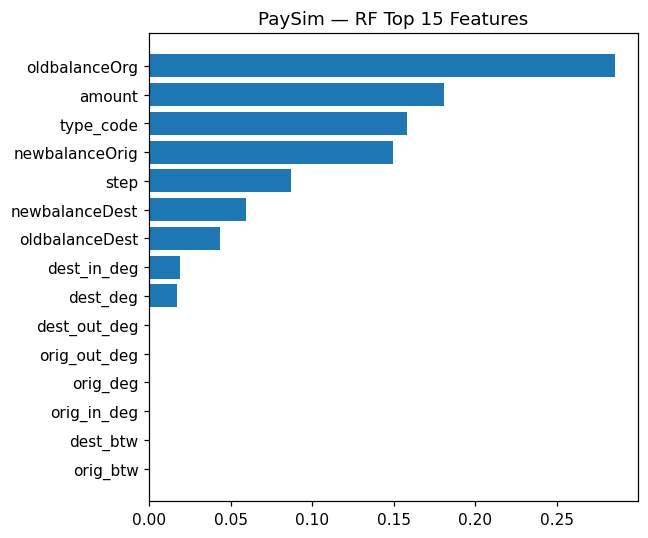

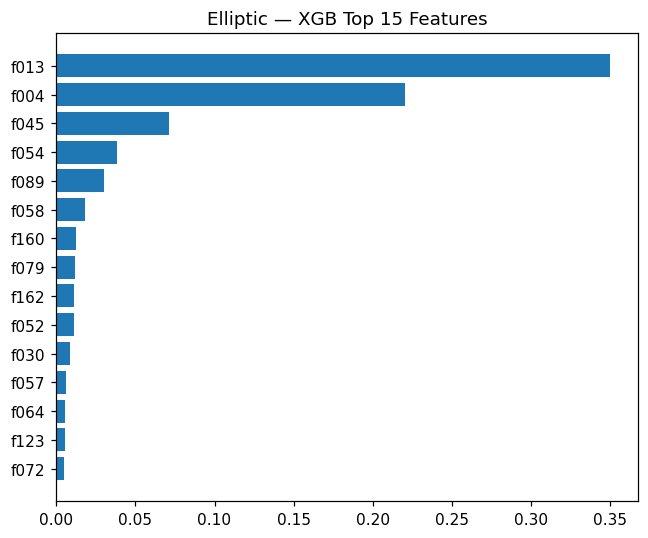

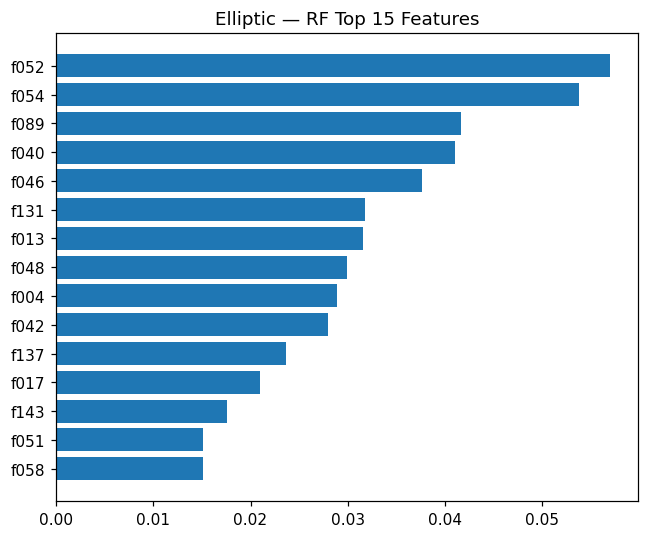

In [29]:
#cell 9c
def plot_top_features(model, feature_names, top_n=15, title="Top Features"):
    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        print("Model has no .feature_importances_.")
        return
    idx = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(6,5))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), np.array(feature_names)[idx])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# PaySim
plot_top_features(xgb, Xtr.columns, top_n=15, title="PaySim — XGB Top 15 Features")
plot_top_features(rf,  Xtr.columns, top_n=15, title="PaySim — RF Top 15 Features")

# Elliptic
plot_top_features(xgb_e, Xe_tr.columns, top_n=15, title="Elliptic — XGB Top 15 Features")
plot_top_features(rf_e,  Xe_tr.columns, top_n=15, title="Elliptic — RF Top 15 Features")


In [30]:
# E1 — Remap labels (1=illicit=positive, 2=licit=negative) and rebuild supervised table

# Reload classes & features cleanly
classes  = pd.read_csv(os.path.join(ELLIPTIC_DIR, "elliptic_txs_classes.csv"))
features = pd.read_csv(os.path.join(ELLIPTIC_DIR, "elliptic_txs_features.csv"), header=None)
features.columns = ["txId", "timeStep"] + [f"f{i:03d}" for i in range(features.shape[1]-2)]

# Correct mapping
label_map = {"1": 1, "2": 0}
classes["label"] = classes["class"].astype(str).map(label_map)

elliptic_df = features.merge(classes[["txId","label"]], on="txId", how="left")
sup_elliptic = elliptic_df.dropna(subset=["label"]).copy()
sup_elliptic["label"] = sup_elliptic["label"].astype("int8")

print("Label distribution (all data):")
print(sup_elliptic["label"].value_counts())



Label distribution (all data):
label
0    42019
1     4545
Name: count, dtype: int64


In [50]:
# E2 — Add SNA features + temporal split (≤34 train, ≥35 test)

edges = pd.read_csv(os.path.join(ELLIPTIC_DIR, "elliptic_txs_edgelist.csv"))
edges.columns = [c.strip() for c in edges.columns]
edges = edges.rename(columns={edges.columns[0]:"src", edges.columns[1]:"dst"})

GE = nx.from_pandas_edgelist(edges, source="src", target="dst", create_using=nx.DiGraph)

degE, inE, outE = dict(GE.degree()), dict(GE.in_degree()), dict(GE.out_degree())
sna_tx = pd.DataFrame({
    "txId": list(GE.nodes()),
    "tx_deg":     [degE.get(n,0) for n in GE.nodes()],
    "tx_in_deg":  [inE.get(n,0)  for n in GE.nodes()],
    "tx_out_deg": [outE.get(n,0) for n in GE.nodes()],
})

sup_elliptic = sup_elliptic.merge(sna_tx, on="txId", how="left").fillna(0.0)
sup_elliptic = memdowncast(sup_elliptic)

feat_cols_e = [c for c in sup_elliptic.columns if c not in ["txId","label"]]
train_mask  = sup_elliptic["timeStep"] <= 34
test_mask   = sup_elliptic["timeStep"] >= 35

Xtr_e, ytr_e = sup_elliptic.loc[train_mask, feat_cols_e], sup_elliptic.loc[train_mask,"label"]
Xte_e, yte_e = sup_elliptic.loc[test_mask,  feat_cols_e], sup_elliptic.loc[test_mask,"label"]

print("Train size:", Xtr_e.shape, " Test size:", Xte_e.shape)
print("Test label counts:", yte_e.value_counts())


Train size: (29894, 169)  Test size: (16670, 169)
Test label counts: label
0    15587
1     1083
Name: count, dtype: int64


In [52]:
# E3 — Train RF/XGB on temporal split, evaluate

rf_e = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=os.cpu_count(),
    random_state=SEED, class_weight="balanced_subsample"
)
xgb_e = XGBClassifier(
    random_state=SEED, n_estimators=400, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, n_jobs=os.cpu_count(),
    tree_method="hist", eval_metric="aucpr"
)

print("Training RF...")
rf_e.fit(Xtr_e, ytr_e); rf_e_scores = rf_e.predict_proba(Xte_e)[:,1]

print("Training XGB...")
xgb_e.fit(Xtr_e, ytr_e); xgb_e_scores = xgb_e.predict_proba(Xte_e)[:,1]

print("\nElliptic (temporal) metrics:")
eval_model("RF (temporal)",  yte_e, rf_e_scores,  k=TOP_K_ALERTS)
eval_model("XGB (temporal)", yte_e, xgb_e_scores, k=TOP_K_ALERTS)

print("\nClassification reports (thr=0.5):")
print("RF:\n", classification_report(yte_e, (rf_e_scores>=0.5).astype(int), digits=4))
print("XGB:\n",classification_report(yte_e, (xgb_e_scores>=0.5).astype(int), digits=4))


Training RF...
Training XGB...

Elliptic (temporal) metrics:
RF (temporal) | ROC-AUC: 0.9371 | PR-AUC: 0.7983 | Precision@2000: 0.4140
XGB (temporal) | ROC-AUC: 0.9351 | PR-AUC: 0.8036 | Precision@2000: 0.4180

Classification reports (thr=0.5):
RF:
               precision    recall  f1-score   support

           0     0.9794    0.9994    0.9893     15587
           1     0.9869    0.6971    0.8171      1083

    accuracy                         0.9797     16670
   macro avg     0.9832    0.8482    0.9032     16670
weighted avg     0.9799    0.9797    0.9781     16670

XGB:
               precision    recall  f1-score   support

           0     0.9815    0.9961    0.9888     15587
           1     0.9284    0.7304    0.8176      1083

    accuracy                         0.9788     16670
   macro avg     0.9550    0.8632    0.9032     16670
weighted avg     0.9781    0.9788    0.9776     16670



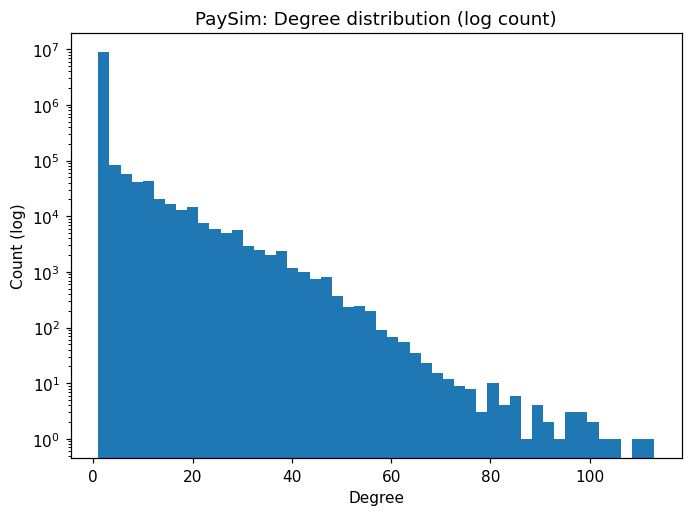

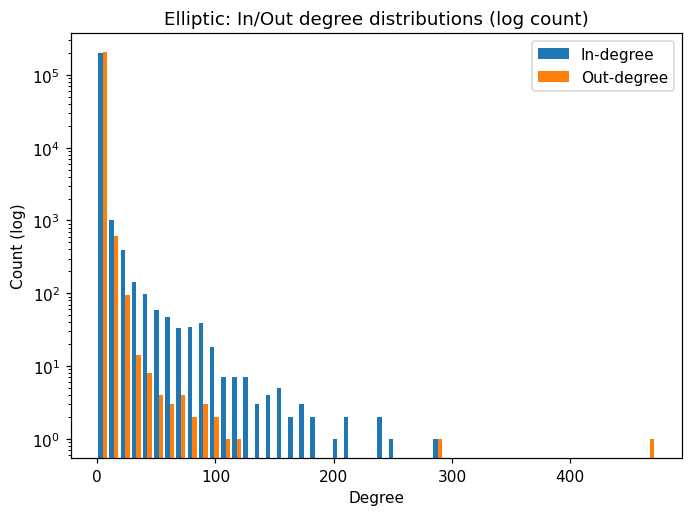

In [58]:
# PaySim degree hist (log scale)
pay_deg = [d for _, d in G.degree()]
plt.figure(); plt.hist(pay_deg, bins=50, log=True)
plt.title("PaySim: Degree distribution (log count)"); plt.xlabel("Degree"); plt.ylabel("Count (log)")
plt.tight_layout(); plt.savefig(FIG_DIR/"paysim_degree_hist.png", dpi=300); plt.show()

# Elliptic in/out-degree hist (log scale)
ell_in  = [d for _, d in GE.in_degree()]
ell_out = [d for _, d in GE.out_degree()]
plt.figure(); plt.hist([ell_in, ell_out], bins=50, log=True, label=["In-degree","Out-degree"])
plt.title("Elliptic: In/Out degree distributions (log count)"); plt.xlabel("Degree"); plt.ylabel("Count (log)")
plt.legend(); plt.tight_layout(); plt.savefig(FIG_DIR/"elliptic_degree_hist.png", dpi=300); plt.show()
